In [51]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [52]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

In [53]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)
def tica(data, lagtime, var_cutoff):
    '''RETURNS: projected data on tics, tica object
    '''
    est = TICA(lagtime=lagtime, var_cutoff = var_cutoff).fit(data)
    tica = est.fetch_model()
    plt.scatter(np.arange(20),tica.singular_values[:20])
    plt.xticks(np.arange(20),np.arange(20))
    plt.title("Eigen Values")
    return tica.transform(data), tica
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

In [54]:
outdir = '/Users/achakrab/Documents/asn/tica'
pdb = '/Users/achakrab/Documents/asn/DESRES-Trajectory-lig47/biorxiv2021-6626290-no-water-glue/lig47.pdb'
rep0 = '/Users/achakrab/Documents/asn/DESRES-Trajectory-lig47/biorxiv2021-6626290-no-water-glue/ligand_47_1.xtc'
#helixpdb = './Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
#apodir = './Trajectory_Files_12.20.21/R2_R3_APO/'

table,bonds = md.load(pdb).topology.to_dataframe()
first = table[table["resSeq"]==121].to_numpy()
first[:,0] = np.arange(1, 1+len(first))
second = table[table["resSeq"]!=121].to_numpy()
second[:,0] = np.arange(first[-1,0]+1, first[-1,0]+1 + len(second))
final = np.concatenate([first, second], axis=0)
df = pd.DataFrame(data = final, columns = table.columns)
top_fix = md.Topology.from_dataframe(df, bonds)
trj = md.load(rep0, top =top_fix)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames

In [55]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)


residue_offset = 0
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)



** SYSTEM INFO **

Number of atoms: 338

Number of residues: 21

Number of protein residues: 20

Number of frames: 1100889

Starting frame: 0

Last frame: 1100889

sequence:  [<1>1, ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140]

residue names:  ['<1>', 'ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



In [56]:
for i in range(trj.n_residues):print([trj.topology.atom(i) for i in trj.topology.select(f"resid {i}")], "\n")

[<1>1-C, <1>1-H, <1>1-H, <1>1-H, <1>1-C, <1>1-O, <1>1-N, <1>1-C, <1>1-H, <1>1-H, <1>1-C, <1>1-H, <1>1-H, <1>1-C, <1>1-C, <1>1-C, <1>1-H, <1>1-C, <1>1-H, <1>1-C, <1>1-C, <1>1-H, <1>1-S, <1>1-O, <1>1-O, <1>1-N, <1>1-C, <1>1-H, <1>1-H, <1>1-C, <1>1-H, <1>1-H, <1>1-C, <1>1-H, <1>1-H, <1>1-N, <1>1-H, <1>1-H, <1>1-C, <1>1-H, <1>1-H, <1>1-C, <1>1-H, <1>1-H] 

[ASP121-N, ASP121-CA, ASP121-C, ASP121-O, ASP121-CB, ASP121-CG, ASP121-OD1, ASP121-OD2, ASP121-H, ASP121-HA, ASP121-HB2, ASP121-HB3, ASP121-H, ASP121-H] 

[ASN122-N, ASN122-CA, ASN122-C, ASN122-O, ASN122-CB, ASN122-CG, ASN122-OD1, ASN122-ND2, ASN122-H, ASN122-HA, ASN122-HB2, ASN122-HB3, ASN122-HD21, ASN122-HD22] 

[GLU123-N, GLU123-CA, GLU123-C, GLU123-O, GLU123-CB, GLU123-CG, GLU123-CD, GLU123-OE1, GLU123-OE2, GLU123-H, GLU123-HA, GLU123-HB2, GLU123-HB3, GLU123-HG2, GLU123-HG3] 

[ALA124-N, ALA124-CA, ALA124-C, ALA124-O, ALA124-CB, ALA124-H, ALA124-HA, ALA124-HB1, ALA124-HB2, ALA124-HB3] 

[TYR125-N, TYR125-CA, TYR125-C, TYR125-O, TYR12

In [57]:
 [trj.topology.residue(i) for i in range(trj.n_residues)]

[<1>1,
 ASP121,
 ASN122,
 GLU123,
 ALA124,
 TYR125,
 GLU126,
 MET127,
 PRO128,
 SER129,
 GLU130,
 GLU131,
 GLY132,
 TYR133,
 GLN134,
 ASP135,
 TYR136,
 GLU137,
 PRO138,
 GLU139,
 ALA140]

In [58]:
def distance_matrix(sel1,sel2,offset1,offset2,traj,measure,periodic):
    ''' RETURNS: dmat,np.array(pairs),np.array(pairs_index),index,columns,len(sel1)..(x),len(sel2)....(y)
    '''
    pair_distances = []
    pairs = []
    pairs_index = []
    if measure == "residues":
        index = [traj.topology.residue(i) for i in sel1]
        columns = [traj.topology.residue(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.residue(i),traj.topology.residue(j)))
                pairs_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_contacts(traj,[[i,j]],periodic=periodic)[0][:,0]
                    pair_distances.append(dist)
    if measure == "atoms":
        index = [traj.topology.atom(i) for i in sel1]
        columns = [traj.topology.atom(j) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.atom(i),traj.topology.atom(j)))
                pairs_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_distances(traj,[[i,j]],periodic=periodic)[:,0]
                    pair_distances.append(dist)
    dist_feat_arr = np.stack(pair_distances,axis=1)
    return dist_feat_arr,np.array(pairs),np.array(pairs_index),index,columns,np.array([len(sel1),len(sel2)])
dmat, pairs, pairs_idx, index, col, xy = distance_matrix(np.arange(1,21),[0], 0,0,trj,"residues", True)
dmat_bin = np.where(dmat<.5,1,0)

In [59]:
dmat_intra = distance_matrix(np.arange(1,21),np.arange(1,21), 0,0,trj,"residues", True)[0]

In [60]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

No handles with labels found to put in legend.


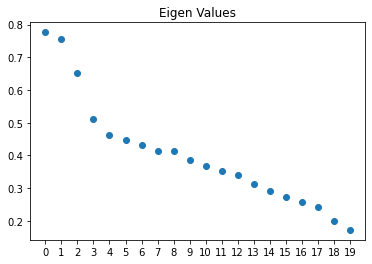

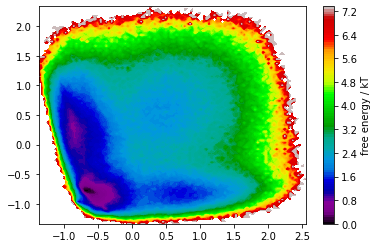

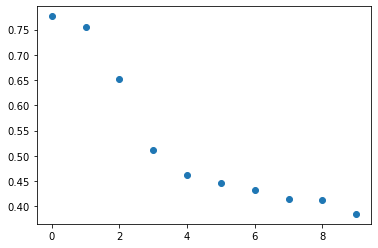

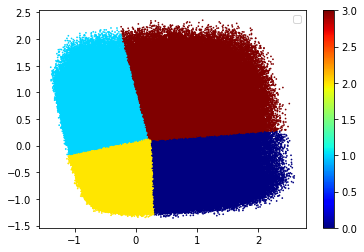

In [61]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##
combined = dmat
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5,cmap = "jet")
plt.colorbar()
plt.legend()

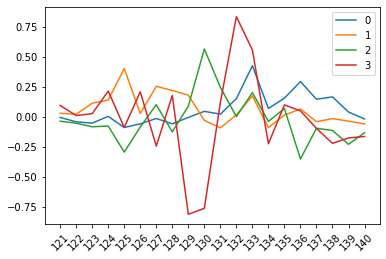

In [62]:
tica_obj = coor.tica(dmat, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

In [63]:
frames_cl

[array([      0,       1,       2, ..., 1100714, 1100720, 1100722]),
 array([    114,     124,     159, ..., 1100886, 1100887, 1100888]),
 array([      4,      35,      36, ..., 1100824, 1100825, 1100826]),
 array([     92,      98,     107, ..., 1100729, 1100730, 1100731])]

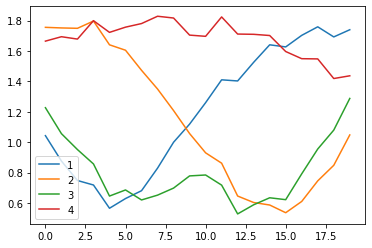

In [64]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()

In [65]:
#contact probabilities
dmat_con_prob = np.sum(dmat_bin, axis =0)/dmat.shape[0]
print (dmat_con_prob)
dmat_con_prob.shape

[0.054 0.080 0.117 0.120 0.251 0.166 0.204 0.172 0.153 0.173 0.155 0.144
 0.331 0.252 0.251 0.320 0.226 0.160 0.149 0.090]


(20,)

In [66]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    plt.tight_layout()
    plt.figure()
    lags_scale = np.arange(1,20)
    its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    pyemma.plots.plot_implied_timescales(its)
    return msm

24-09-22 19:01:46 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[103] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.425473539876696


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.56it/s]


24-09-22 19:01:48 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[108] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.1011495036100003


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19.87it/s]


24-09-22 19:01:51 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[113] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.3798478261092935


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 23.44it/s]


24-09-22 19:01:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[118] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.1700469147842971


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 20.75it/s]


24-09-22 19:01:56 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[123] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.0111133081355197


100%|███████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.93it/s]


array([MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=5, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=10, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=50, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, st

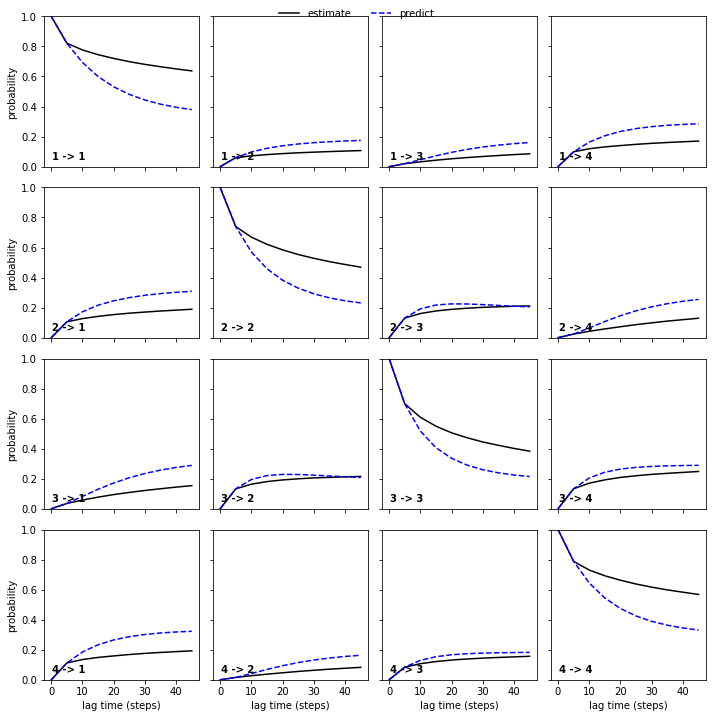

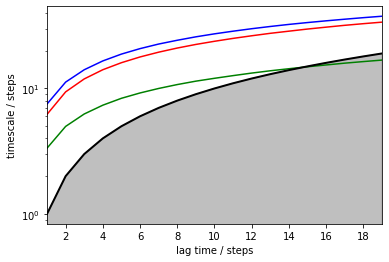

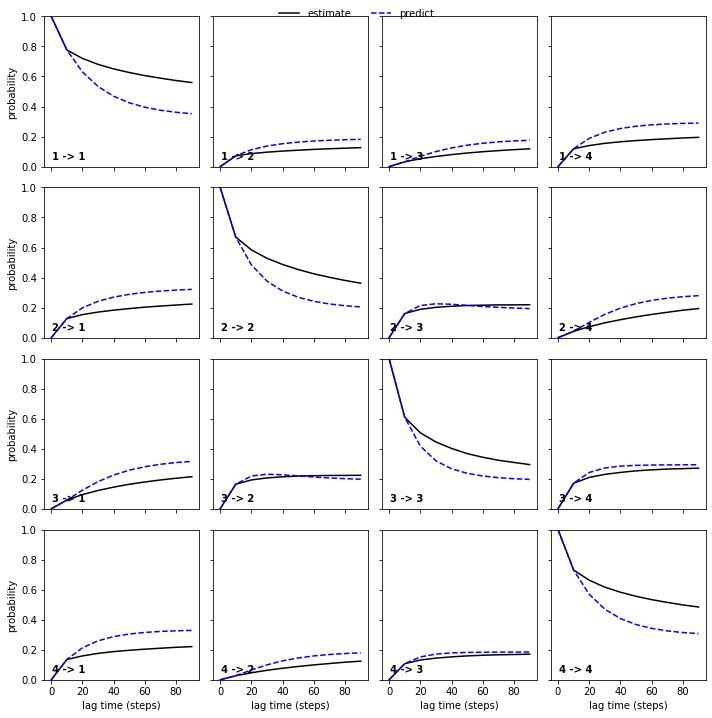

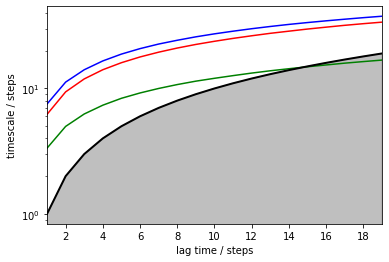

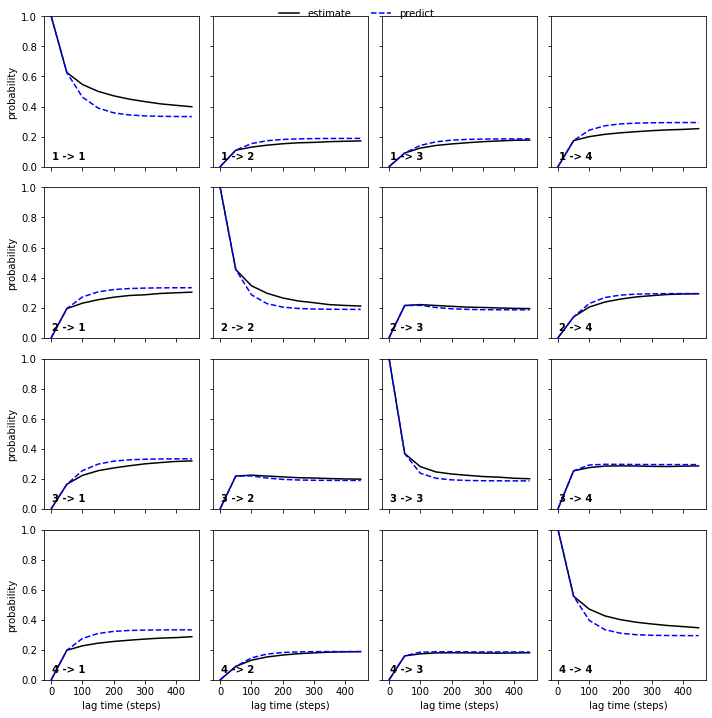

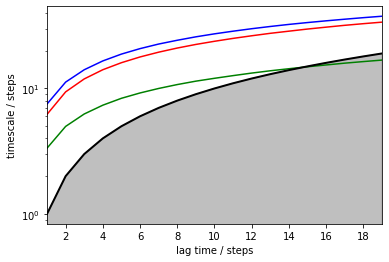

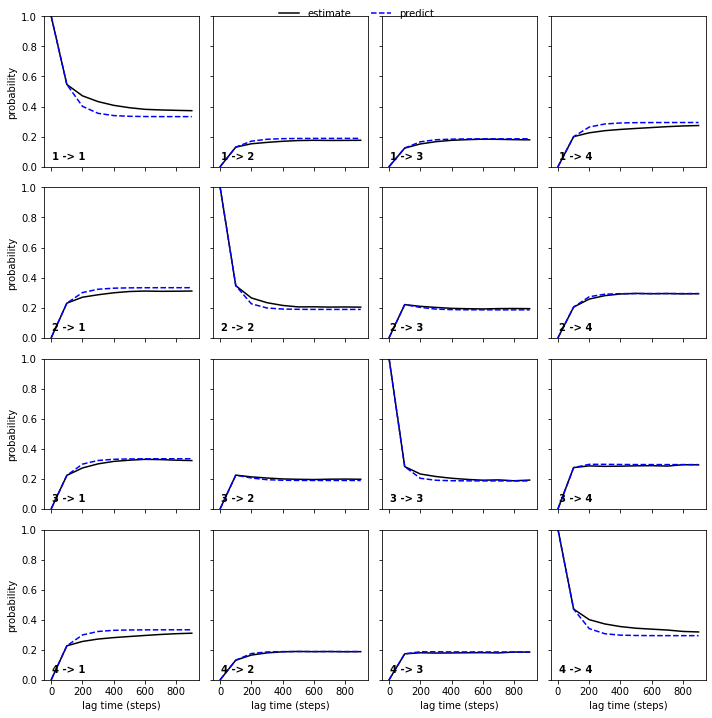

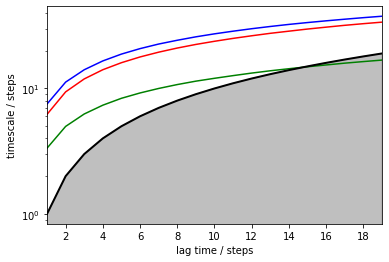

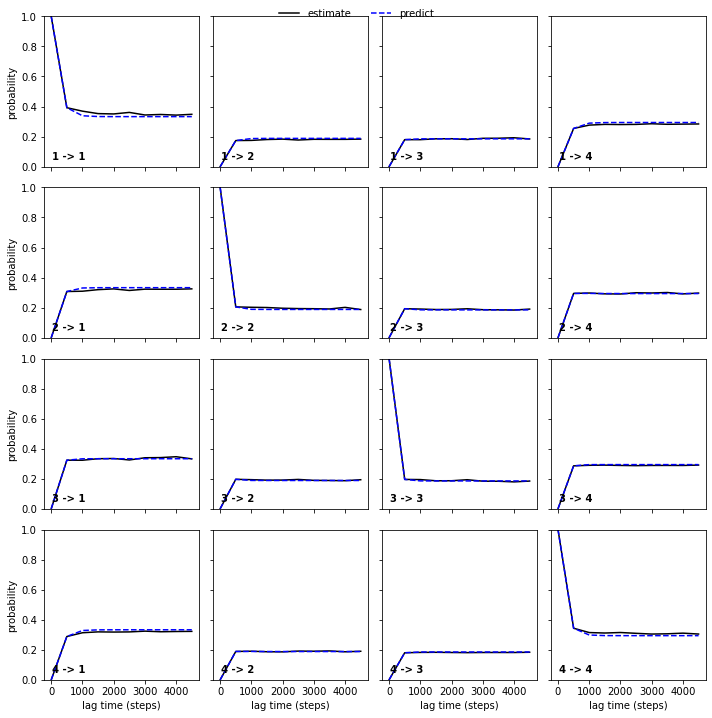

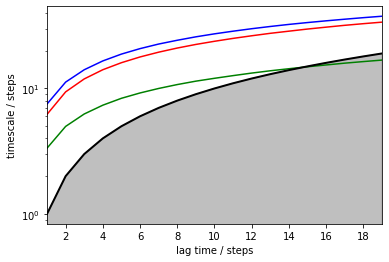

In [26]:
#dmat
msm = []
for i in [5,10,50,100,500]:
    msm.append(makem(dtraj, 4, i))
np.hstack(msm)

In [28]:
np.shape(msm)

(5,)

([<matplotlib.axis.XTick at 0x7fc690f31e50>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

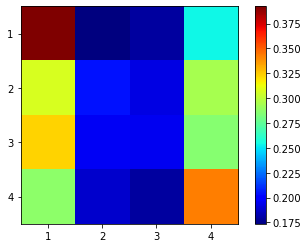

In [35]:
plt.imshow(msm[4].transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [68]:
trj[frames_cl[0]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_cluster_4.dcd") #save frames

[[0.780 0.699 0.750 ... 0.060 0.303 0.038]
 [0.689 0.636 0.727 ... 0.039 0.254 0.043]
 [0.825 0.776 0.786 ... 0.048 0.359 0.048]
 ...
 [0.010 0.014 0.099 ... 0.941 0.911 0.834]
 [0.009 0.026 0.034 ... 0.943 0.956 0.873]
 [0.008 0.005 0.018 ... 0.933 0.875 0.893]]


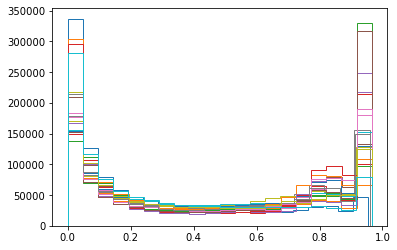

In [69]:
#dists = np.arange(0, 10, 0.1)
def sigmoid(x):
    z = np.exp((-4*x+4))
    sig = 1- 1 / (1 + z)
    return sig

dmat_sig=sigmoid(dmat)

for i in range(0,20):
   plt.hist((dmat_sig[:,i]),histtype='step',bins=20,label=i) 

print (dmat_sig)

No handles with labels found to put in legend.


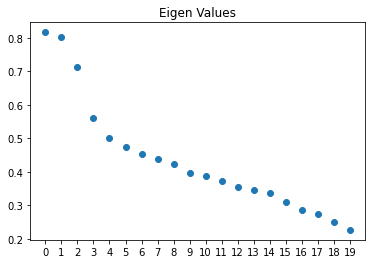

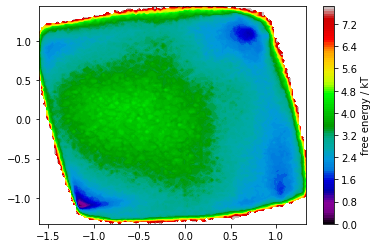

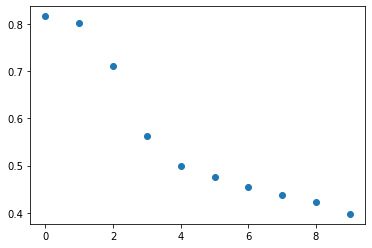

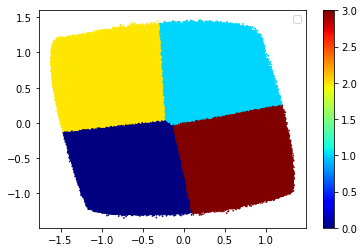

In [71]:
##adjustable params
space = 1
dim = 2
n_clusters = 4
lag = 10
##
combined = dmat_sig
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5,cmap = "jet")
plt.colorbar()
plt.legend()

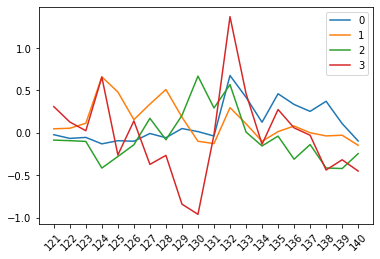

In [38]:
tica_obj = coor.tica(dmat_sig, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

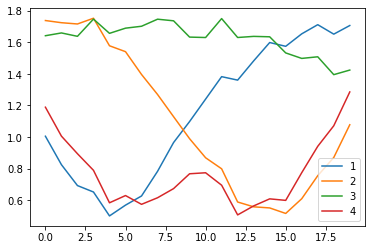

In [39]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()

In [40]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    plt.tight_layout()
    plt.figure()
    lags_scale = np.arange(1,20)
    its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    pyemma.plots.plot_implied_timescales(its)
    return msm

24-09-22 19:10:54 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[131] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.602555638958264


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 20.94it/s]


24-09-22 19:10:57 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[136] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.2735225076440444


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.12it/s]


24-09-22 19:10:59 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[141] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.4545691099545048


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 20.01it/s]


24-09-22 19:11:02 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[146] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.20601400680351


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19.80it/s]


24-09-22 19:11:04 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[151] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.012839466721694


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 20.65it/s]


array([MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=5, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=10, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=50, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, st

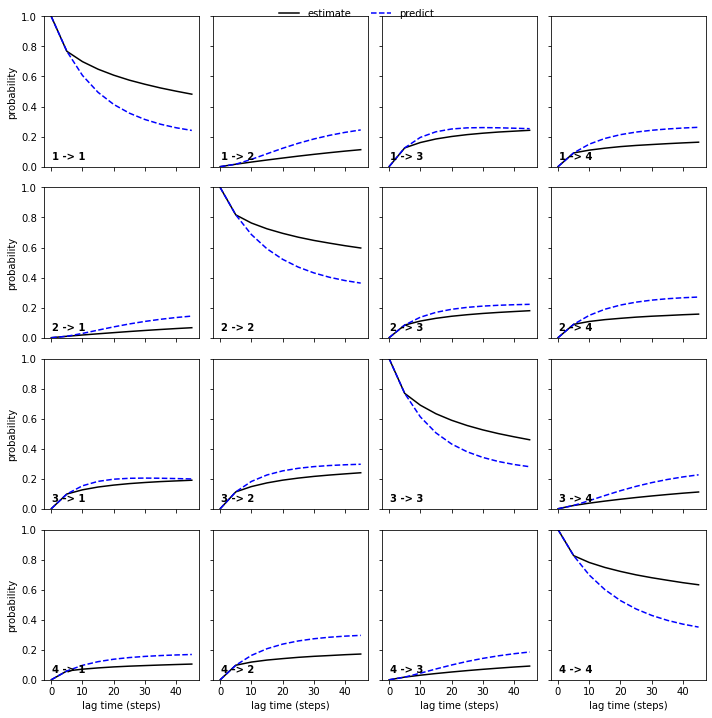

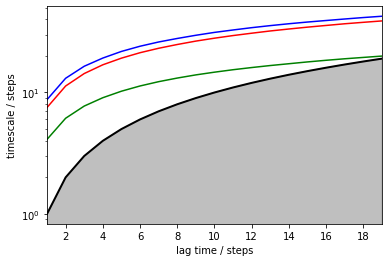

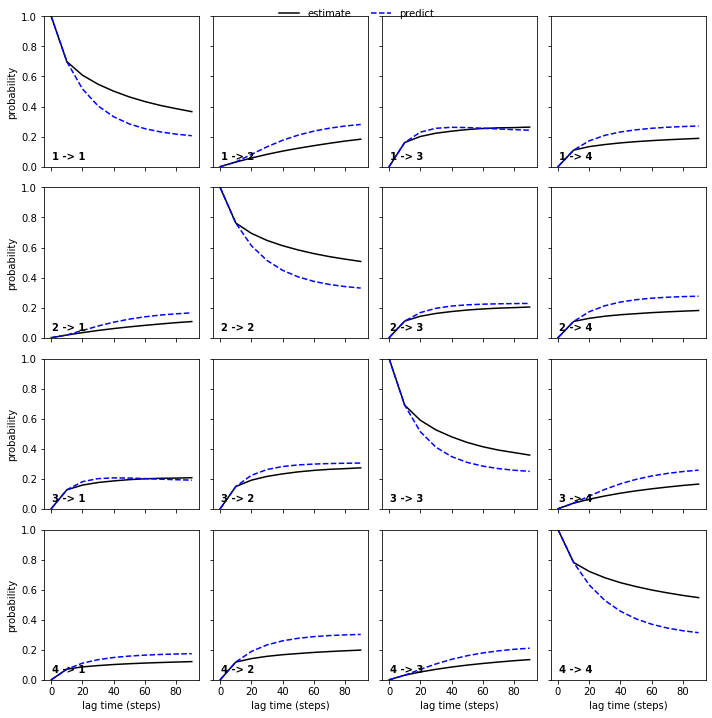

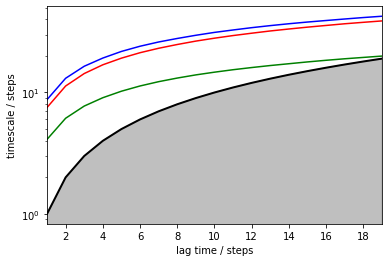

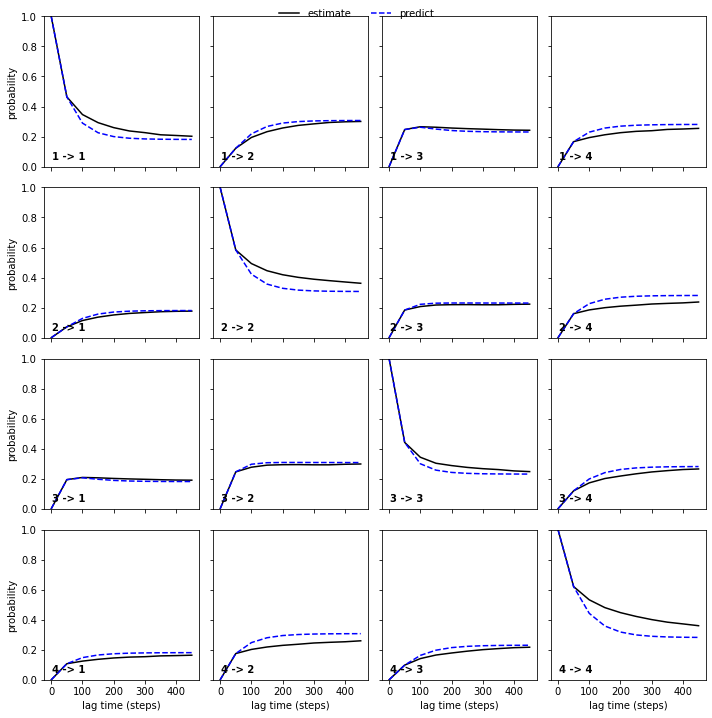

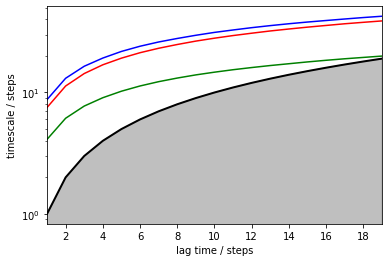

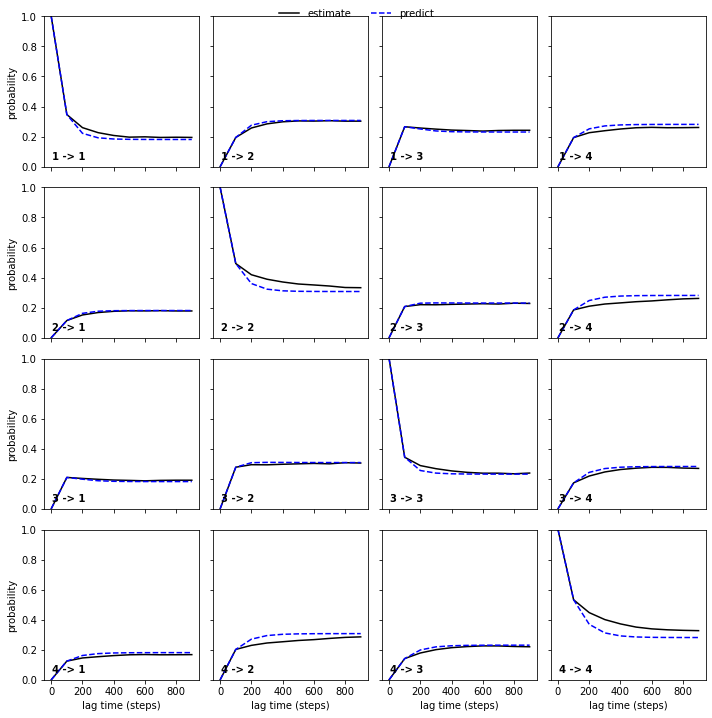

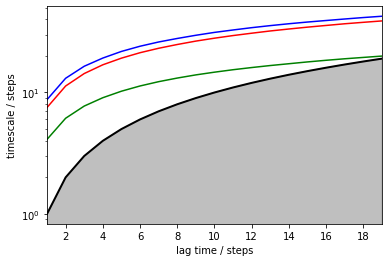

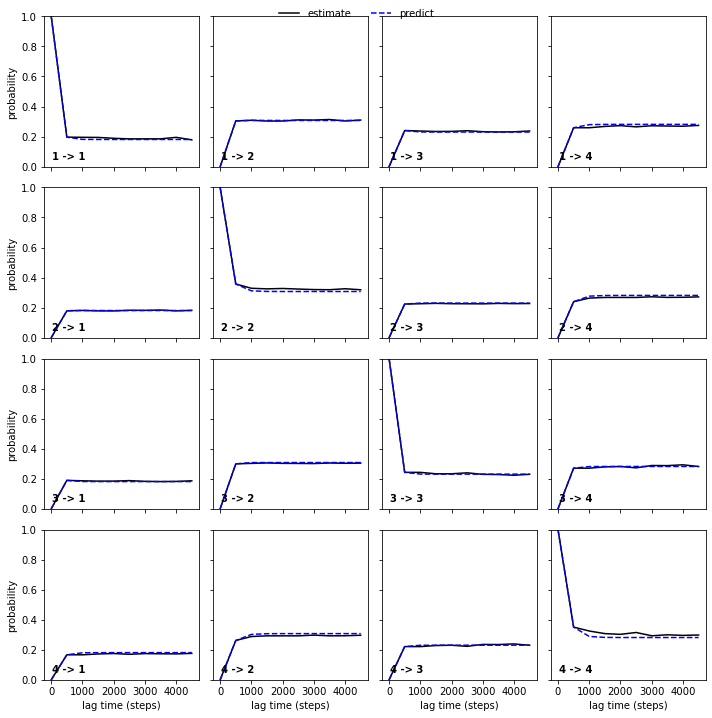

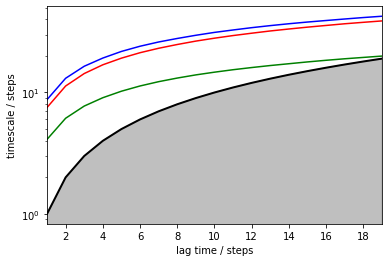

In [41]:
#dmat_sig
msm = []
for i in [5,10,50,100,500]:
    msm.append(makem(dtraj, 4, i))
np.hstack(msm)

([<matplotlib.axis.XTick at 0x7fc6952e60a0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

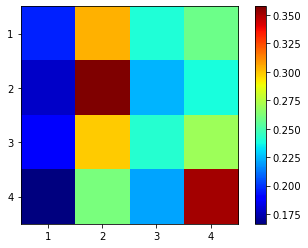

In [42]:
plt.imshow(msm[4].transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [72]:
trj[frames_cl[0]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_sig_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_sig_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_sig_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_sig_cluster_4.dcd") #save frames

<Figure size 432x288 with 0 Axes>

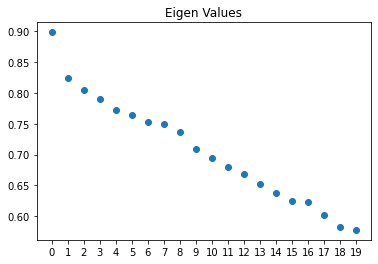

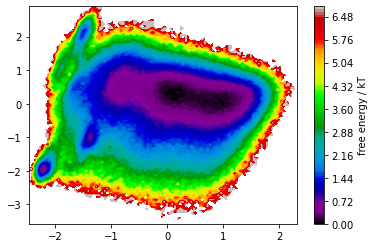

<Figure size 432x288 with 0 Axes>

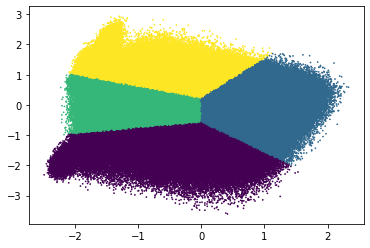

<Figure size 432x288 with 0 Axes>

In [73]:
#distance all to all with single spacing
##adjustable params
space = 4
dim = 2
n_clusters = 4
lag = 10
##
combined = np.concatenate([dmat,dmat_intra[:,res_space(20,space)]], axis = 1)
proj_combined, tica_combined = tica(combined,lag, .7)
pyemma.plots.plot_free_energy(*proj_combined[:,:2].T)
plt.figure()
#plt.scatter(np.arange(len(tica_combined.singular_values[:10])), tica_combined.singular_values[:10])
dtraj,frames_cl, clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()
plt.scatter(*proj_combined[:,:2].T, c = dtraj, s=.5)
dtraj,frames_cl,clustercenters = kmeans(proj_combined[:,:dim], n_clusters)
plt.figure()

100%|█████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.44s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (260,)

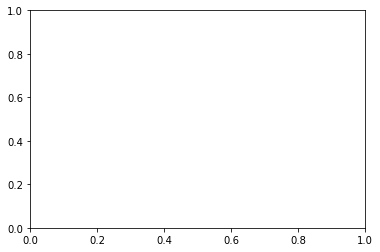

In [87]:
tica_obj = coor.tica(combined, lag=10)
A = tica_obj.eigenvectors

for i in range(0,4):
 plt.plot(prot_res_renum[0:20],A[:,i],label='%s'%i)

plt.xticks(prot_res,prot_res,rotation=45)
plt.legend()

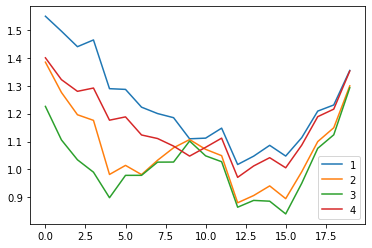

In [75]:
c0_i=frames_cl[0]
c1_i=frames_cl[1]
c2_i=frames_cl[2]
c3_i=frames_cl[3]

plt.plot(np.average(dmat[c0_i],axis=0),label='1')
plt.plot(np.average(dmat[c1_i],axis=0),label='2')
plt.plot(np.average(dmat[c2_i],axis=0),label='3')
plt.plot(np.average(dmat[c3_i],axis=0),label='4')
plt.legend()

In [45]:
population = [len(i)/trj.n_frames for i in frames_cl]
population_percentage = [100*len(i)/trj.n_frames for i in frames_cl]

In [46]:
def makem(ddtraj,nsets,lag):
    msm = pyemma.msm.estimate_markov_model(ddtraj, lag=lag)
    print(msm.score(ddtraj))
    pyemma.plots.plot_cktest(msm.cktest(nsets=nsets,memberships=np.eye(nsets)))
    plt.tight_layout()
    plt.figure()
    lags_scale = np.arange(1,20)
    its = pyemma.msm.its(ddtraj,lags = lags_scale, nits=nsets-1,errors = None)
    pyemma.plots.plot_implied_timescales(its)
    return msm

24-09-22 19:33:48 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[186] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.462782405696559


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.66it/s]


24-09-22 19:33:50 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[191] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

2.2682505243342517


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 22.97it/s]


24-09-22 19:33:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[196] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.7739542679580187


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.00it/s]


24-09-22 19:33:55 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[201] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.5448512512170636


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 22.16it/s]


24-09-22 19:33:58 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[206] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 4


estimating MaximumLikelihoodMSM:   0%|                                | 0/9 [00:00<?, ?it/s]

1.1493854894686377


100%|███████████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.00it/s]


array([MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=5, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=10, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, statdist_constraint=None),
       MaximumLikelihoodMSM(connectivity='largest', core_set=None,
           count_mode='sliding', dt_traj='1 step', lag=50, maxerr=1e-08,
           maxiter=1000000, milestoning_method='last_core',
           mincount_connectivity='1/n', reversible=True, score_k=4,
           score_method='VAMP2', sparse=False, st

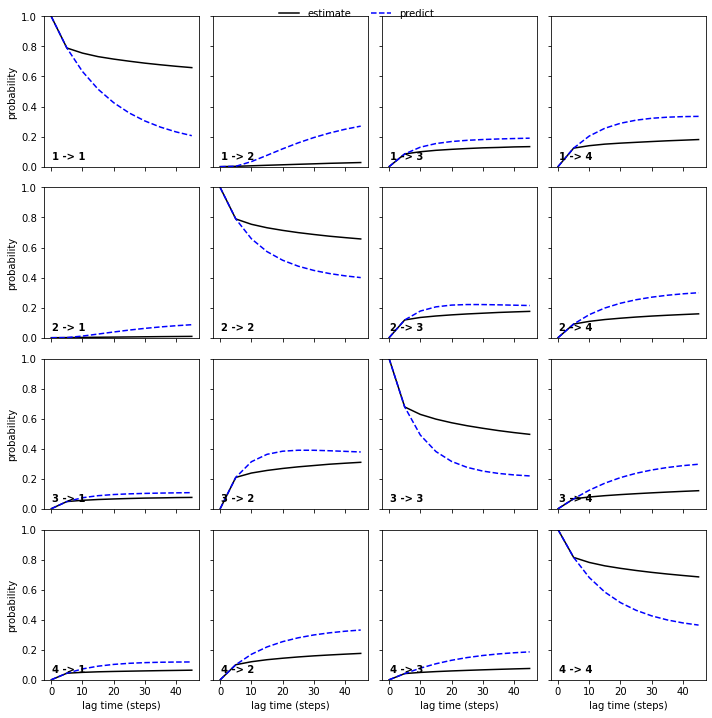

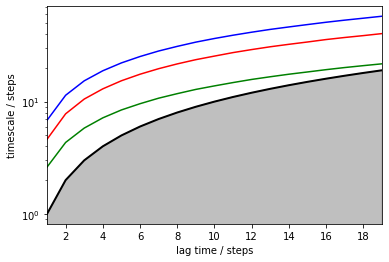

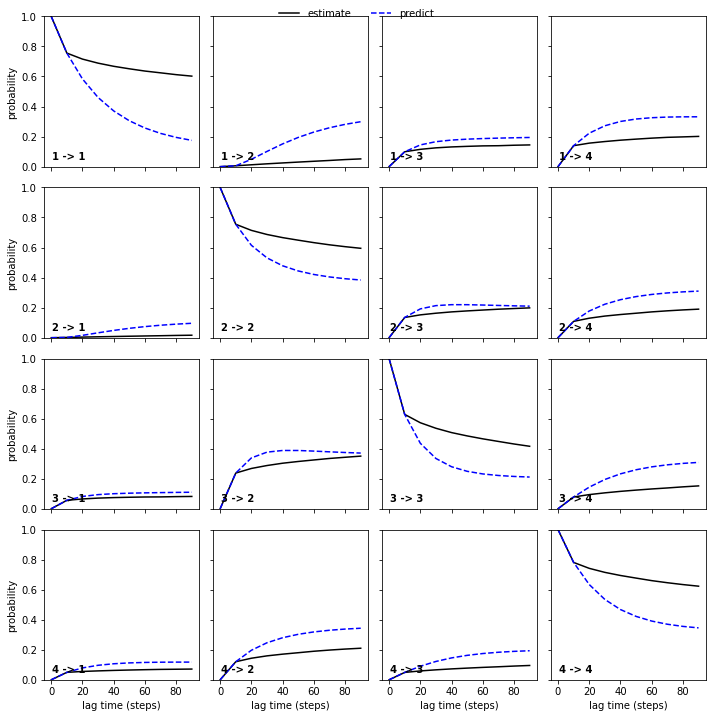

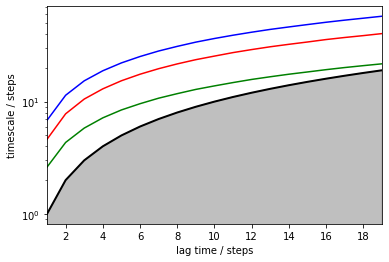

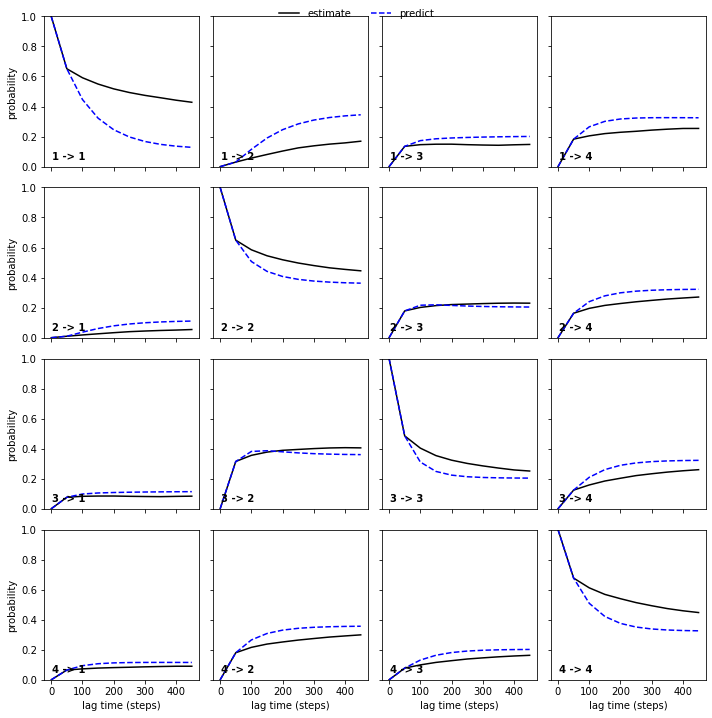

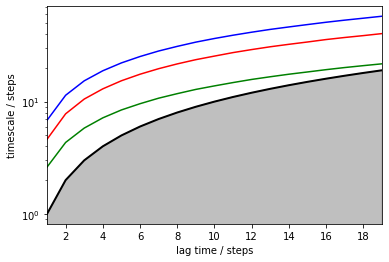

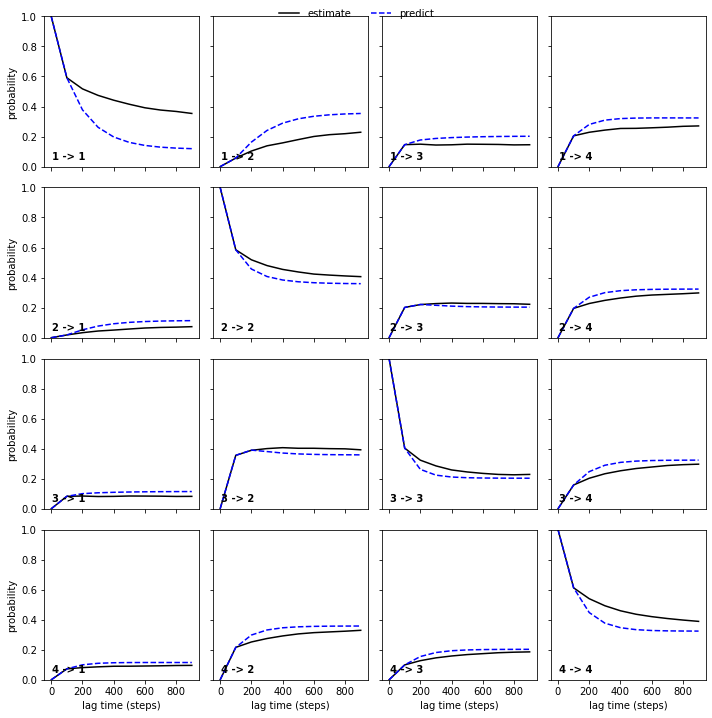

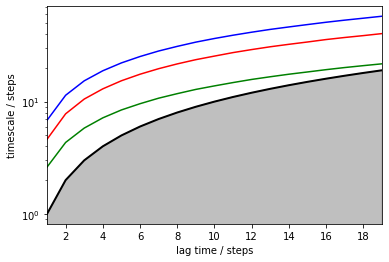

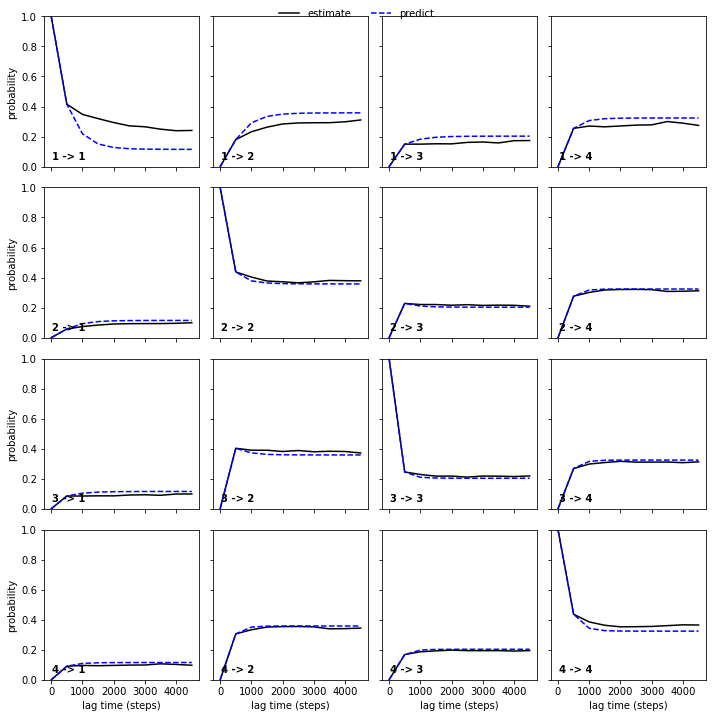

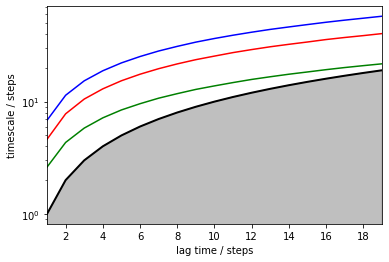

In [49]:
#all to all
msm = []
for i in [5,10,50,100,500]:
    msm.append(makem(dtraj, 4, i))
np.hstack(msm)

([<matplotlib.axis.XTick at 0x7fc691c76280>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

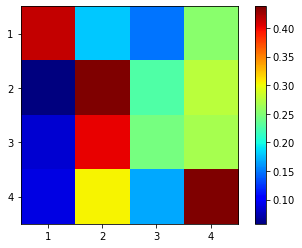

In [50]:
plt.imshow(msm[4].transition_matrix,cmap = "jet")
plt.colorbar()
plt.yticks(np.arange(4),np.arange(1,5))
plt.xticks(np.arange(4),np.arange(1,5))

In [76]:
trj[frames_cl[0]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_all_cluster_1.dcd") #save frames
trj[frames_cl[1]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_all_cluster_2.dcd") #save frames
trj[frames_cl[2]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_all_cluster_3.dcd") #save frames
trj[frames_cl[3]].save_dcd("/Users/achakrab/Documents/asn/tica/lig_47_all_cluster_4.dcd") #save frames